## Para correr esta notebook primero debemos estar corriento el HOST

## Importamos las librerías que vamos a utilizar

In [1]:
# Importamos nuestra librería con funciones que nos ayudan a identificar y reproducir el .MID seleccionado
from commons_play_mid import play_music, play_song, get_song

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Algunas de las de siempre
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Las que vamos a necesitar para hacer los llamados y para lidiar con los datos en formato json
import requests
from flask import  Flask, request, jsonify#, render_template
import json
ROOT = 'Full_MIDI/'

### Generamos un DataFrame con los directorios donde se encuentran los .MID

## Definimos algunos valores por defecto

### IMPORTANTE:
* Search= --> Refiere a buscar dentro de la lista de temas preexistentes, si 'False' levanta un .MID de la carpeta /GET_FILE
* Predict='True' --> Devuelve temas solo dentro del género predicho
* Podemos crear presets alternativos y modificar valores

In [3]:
search=False # si 'False' levanta un .MID de la carpeta /GET_FILE
cant_resultados = 5
url = 'http://localhost:5000/related_songs'
predict='False' # Devuelve temas solo dentro del género predicho
penalizacion = 1

## Vamos a generar 3 presets de busqueda
* get_balanced_params: Balanceado
* get_rytmic_instrument_params: Toma los los aspectos ritmicos de todos los intrumentos
* get_rytmic_params: Toma los aspectos ritmicos solo de los instrumentos percusivos

In [4]:
def get_balanced_params(
    duracion_notas = 1,
    amplitud_tonal = 1,
    ritmica_instrument = 2,
    ritmica_drums = 2,
    armonia = 1,
    dinamica = 1,
    instrumentacion = 1,
    tempo = 1,
    notas_simultaneas = 1,
    duracion_tema = 1,
    others=1):

    return duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others

In [5]:
#Params set de busqueda ritmica
def get_rytmic_instrument_params(
    duracion_notas = 0,
    amplitud_tonal = 0,
    ritmica_instrument = 8,
    ritmica_drums = 8,
    armonia = 0,
    dinamica = 0,
    instrumentacion = 0,
    tempo = 10,
    notas_simultaneas = 0,
    duracion_tema = 0,
    others=0):

    return duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others

In [6]:
#Params set de busqueda ritmica
def get_rytmic_params(
    duracion_notas = 0,
    amplitud_tonal = 0,
    ritmica_instrument = 0,
    ritmica_drums = 10,
    armonia = 0,
    dinamica = 0,
    instrumentacion = 0,
    tempo = 10,
    notas_simultaneas = 0,
    duracion_tema = 0,
    others=0):

    return duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others

In [31]:
#Params set de busqueda ritmica
def get_armonic_params(
    duracion_notas = 0,
    amplitud_tonal = 0,
    ritmica_instrument = 0,
    ritmica_drums = 0,
    armonia = 10,
    dinamica = 0,
    instrumentacion = 0,
    tempo = 0,
    notas_simultaneas = 0,
    duracion_tema = 1,
    others=0):

    return duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others

## Generamos una funcion que obtiene los resultados de busqueda en base a los parametros que enviamos y el preset

In [7]:
def get_simil(song1, song2, filtrar=False, preset=get_balanced_params(), penalizacion=penalizacion, return_df=True):
    
    duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others = preset
      
    # Hacemos el pedido y vemos los resultados.
    # Si todo salió bien en la carpeta "modelos" se tiene que haber generado un .pkl con el modelo entrenado
    relateds = requests.get('http://localhost:5000/similarity_songs', 
                        params = {'instrumentacion':instrumentacion,
                                 'ritmica_drums':ritmica_drums ,
                                 'ritmica_instrument':ritmica_instrument ,
                                 'amplitud_tonal':amplitud_tonal ,
                                 'dinamica':dinamica, 
                                 'duracion_notas':duracion_notas, 
                                 'notas_simultaneas':notas_simultaneas ,
                                 'tempo':tempo, 
                                 'duracion_tema':duracion_tema ,
                                 'armonia':armonia,
                                 'others':others, #otras columnas
                                 'penalizacion':penalizacion,
                                 'filtrar':filtrar,
                                 'song1':song1,
                                 'song2':song2})

    df_simil = pd.DataFrame.from_dict(relateds.json(), "index")
    #display(df_simil)
    df_simil = df_simil.sort_index()
    
    
    if (filtrar==False):
        hm = df_simil.to_numpy()
        hm = hm.reshape(16,41)
        plt.subplots(figsize=(10,5))
        hm = hm.max() - hm
        sns.heatmap(hm)
    else:
        hm = df_simil.T.to_numpy()**(1/penalizacion)
        plt.subplots(figsize=(min(40,int(df_simil.shape[0] / 3)) ,0.5))
        hm = hm.max() - hm
        sns.heatmap(hm,xticklabels=df_simil.index,cmap='viridis')
    if (return_df):
        return df_simil[0]   

In [81]:
def get_relateds(search=False, predict=False, filtrar=True, preset=get_balanced_params(), n_resultados=cant_resultados, penalizacion=penalizacion, clusterizar=True):
    
    duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others = preset
      
    # Hacemos el pedido y vemos los resultados.
    # Si todo salió bien en la carpeta "modelos" se tiene que haber generado un .pkl con el modelo entrenado
    relateds = requests.get(url, 
                        params = {'search':search,
                                  'predict':predict,
                                 'cant_resultados':n_resultados ,
                                 'instrumentacion':instrumentacion,
                                 'ritmica_drums':ritmica_drums ,
                                 'ritmica_instrument':ritmica_instrument ,
                                 'amplitud_tonal':amplitud_tonal ,
                                 'dinamica':dinamica, 
                                 'duracion_notas':duracion_notas, 
                                 'notas_simultaneas':notas_simultaneas ,
                                 'tempo':tempo, 
                                 'duracion_tema':duracion_tema ,
                                 'armonia':armonia,
                                 'others':others, #otras columnas
                                 'penalizacion':penalizacion,
                                 'filtrar':filtrar,
                                  'clusterizar': clusterizar
                                 })
    df_relateds = pd.DataFrame.from_dict(relateds.json(), "index")
#     display(df_relateds)
    return df_relateds   

In [9]:
def get_simil_df(df, filtrar=False, preset=get_balanced_params(), penalizacion=penalizacion):
    
    dict = {}
    song1 = df.index[0]
    for song2 in df.iloc[1:df.shape[0],:].index:
        duracion_notas, amplitud_tonal, ritmica_instrument, ritmica_drums, armonia, dinamica, instrumentacion, tempo, notas_simultaneas, duracion_tema, others = preset

        # Hacemos el pedido y vemos los resultados.
        # Si todo salió bien en la carpeta "modelos" se tiene que haber generado un .pkl con el modelo entrenado
        relateds = requests.get('http://localhost:5000/similarity_songs', 
                            params = {'instrumentacion':instrumentacion,
                                     'ritmica_drums':ritmica_drums ,
                                     'ritmica_instrument':ritmica_instrument ,
                                     'amplitud_tonal':amplitud_tonal ,
                                     'dinamica':dinamica, 
                                     'duracion_notas':duracion_notas, 
                                     'notas_simultaneas':notas_simultaneas ,
                                     'tempo':tempo, 
                                     'duracion_tema':duracion_tema ,
                                     'armonia':armonia,
                                     'others':others, #otras columnas
                                     'penalizacion':penalizacion,
                                     'filtrar':filtrar,
                                     'song1':song1,
                                     'song2':song2})


        dict[song2] = relateds.json()

        
    df_simil = pd.DataFrame.from_dict(dict, "index")
    df_simil.sort_index(axis=1, inplace=True)
    df_simil.fillna(0,inplace=True)
    #display(df_simil)
    hm = df_simil.to_numpy()**(1/penalizacion)
    plt.subplots(figsize=(39,0.5*df_simil.shape[0]))
    #sns.set(font_scale=1.5)
    hm = hm.max() - hm
    sns.heatmap(hm,xticklabels=df_simil.columns.to_list(),yticklabels=df_simil.index,cmap='viridis')

In [10]:
# Interrupt Kernel para frenar la reproducción
def play_song_n(index=1):
    recomendado_n = index # 1 devuelve el original
    song = df_relateds.index[recomendado_n - 1]
    song
    print('Lista actual:')
    display(df_relateds)
    print('Escuchando:')
#     play_song(get_song(song,df_files))
    play_song(ROOT+song)


### IMPORTANTE:

* En la funcion play_song_n(index) --> index es el indice del tema que va a ejecutar dentro de los resultados devueltos
* Interrupt Kernel para frenar la reproducción

## INFO de los metodos que vamos a usar a continuación:

### Get_related() devuelve un dataFrame con los indices de los temas mas parecidos a los que estamos buscando
permite buscar temas dentro del df o subir uno nuevo, limitar busqueda a parametros no nulos (para evitar la similitud entre parametros nulos), cargar presets y agregar penalizaciones

### Get_simil(song1,song2) devuelve un grafico con la diferencia entre dos temas cualesquiera del dataset
permite filtrar, cargar presets y agregar penalizaciones

### Get_simil_df(df,**) devuelve un grafico con la diferencia entre el primer tema y el resto del dataframe
permite filtrar, cargar presets y agregar penalizaciones

In [75]:
# Buscamos un tema de - rnd
df_bossa1 = get_relateds(search="Bossa", filtrar=False,n_resultados=15, preset=get_balanced_params())

,0
A/A/Azure-Bossa-Nova.mid,1.000000
W\W\Walk-Softly.mid,0.977010
W\W\Way's-Cross-Town.mid,0.971788
D\D\Devine-Comedy.mid,0.962701
Guitar_midkar.com_MIDIRip\jazz\brazilian_like-Michel-Pertrucciani_dm.mid,0.943209
T/T/Twin-Dolphins.mid,0.932026
J/J/JP063.MID,0.929899
J/J/jp108.mid,0.918307
C/C/Crescent-Bay.mid,0.915132
D\D\Desert-Heart.mid,0.912882


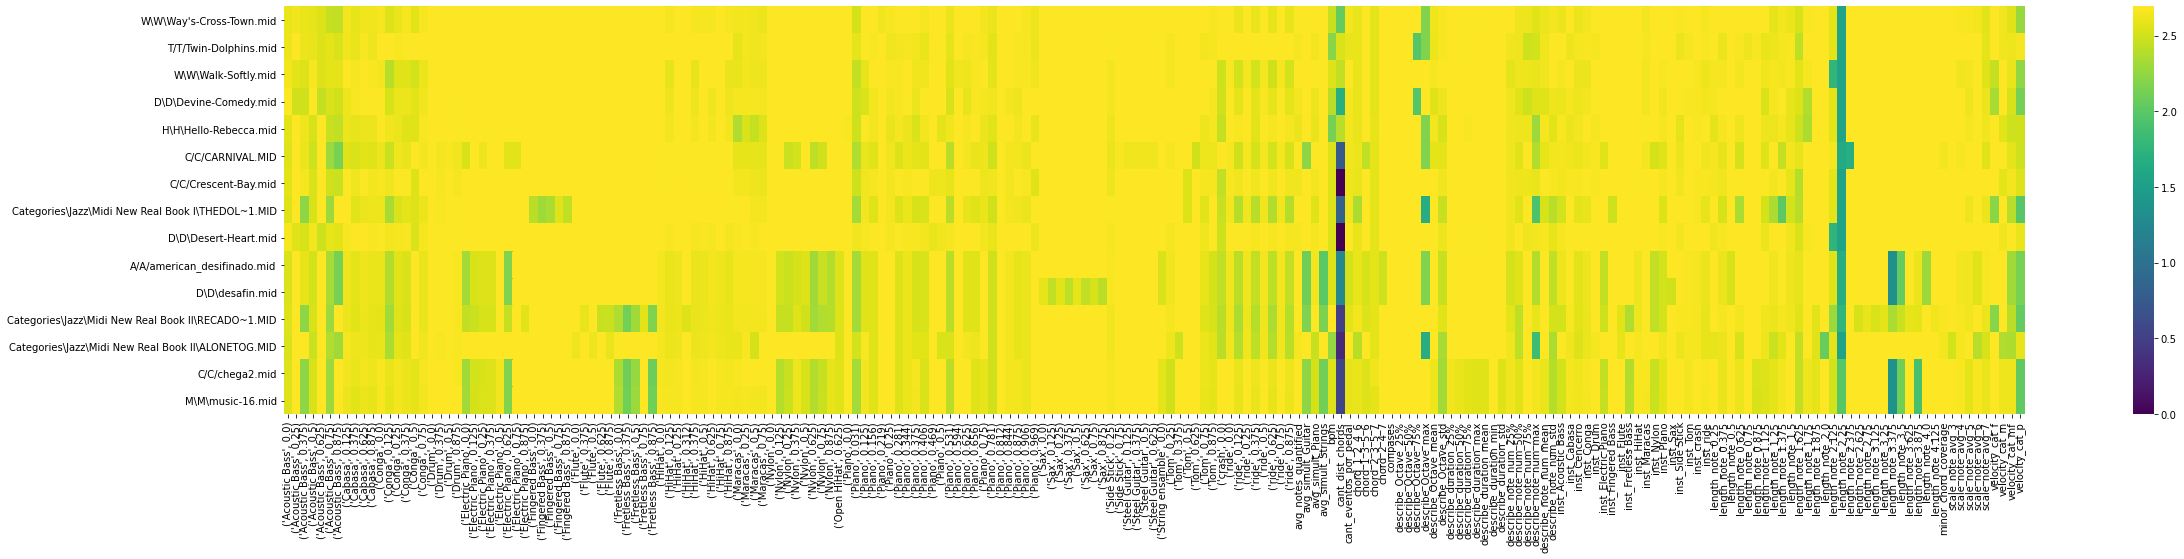

In [12]:
get_simil_df(df_bossa1, filtrar=True, preset=get_balanced_params())

In [12]:
# Buscamos un tema de - rnd
df_jazz1 = get_relateds(search="DONNALEE.MID", filtrar=False,n_resultados=10, preset=get_rytmic_instrument_params())

,0
Categories\Jazz\Midi New Real Book I\DONNALEE.MID,1.000000
Categories\Jazz\Midi New Real Book I\ESP.MID,0.999725
Categories\Jazz\Midi New Real Book I\AIREGIN.MID,0.999673
Categories\Jazz\Midi New Real Book II\SOLAR.MID,0.999579
Categories\Jazz\Midi New Real Book I\BILLYBOY.MID,0.999415
Categories\Jazz\Midi New Real Book II\AIRMAILS.MID,0.999047
Categories\Jazz\Midi New Real Book I\OLEO.MID,0.999034
Categories\Jazz\Midi New Real Book I\GIANTS~1.MID,0.998876
Categories\Jazz\Midi New Real Book II\YELLOW~2.MID,0.998840
Categories\Jazz\Midi New Real Book I\FIRMROOT.MID,0.998780


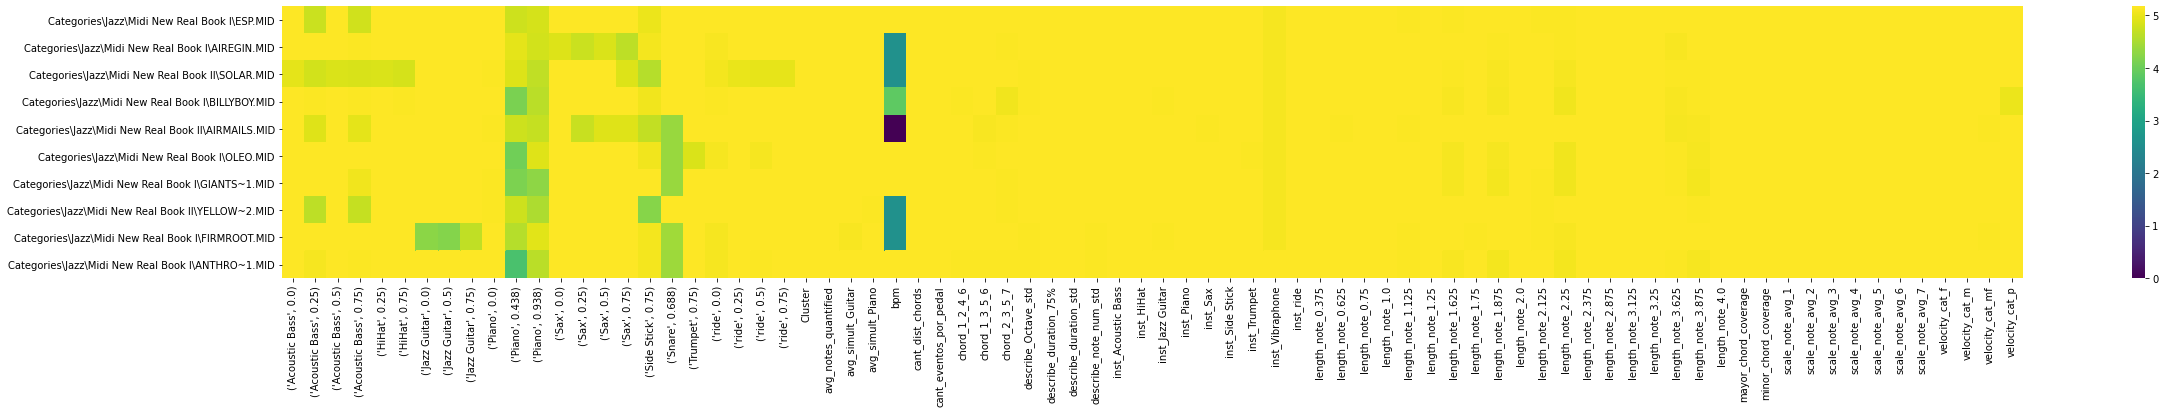

In [14]:
get_simil_df(df_jazz1, filtrar=True, preset=get_rytmic_instrument_params())

In [13]:
# Buscamos un tema de - rnd
df_latina = get_relateds(search="Caminito", filtrar=False,n_resultados=10, preset=get_balanced_params())

,0
C/C/Caminito_GM2.mid,1.000000
B/B/burbujas2.mid,0.735547
B/B/borbulh.mid,0.732380
B/B/Balla-Balla-Ballerino.mid,0.658709
D\D\dontcry05.mid,0.655992
K/K/KEATING.Love is a roller coaster k.mid,0.649799
Guitar_midkar.com_MIDIRip\MidiStudio\LGorven\cicada.mid,0.646855
Categories\By ARTIST\COREL COLLECTION\LITE_10.MID,0.641469
D\D\Dschingis-Khan-Medley-(Medley)-1.mid,0.633842
A/A/a_ha-hunting_high_and_low.mid,0.632561


In [14]:
# Buscamos un tema de - rnd
df_milonga = get_relateds(search="Milonga", filtrar=False,n_resultados=10, preset=get_balanced_params())

,0
Categories\TANGO\acroche2\Milonga.mid,1.000000
Categories\TANGO\acroche2\Cancion de Buenos Aires.mid,0.963125
Categories\TANGO\tangoargentino.com\ulticurd.mid,0.954971
Categories\TANGO\acroche2\Curda.mid,0.954869
Categories\TANGO\tangoargentino.com\elporten.mid,0.954572
Categories\TANGO\tangoargentino.com\trenzas.mid,0.953967
Categories\TANGO\tangoargentino.com\elentrer.mid,0.952006
9/9dejulio.mid,0.950639
Categories\TANGO\acroche2\Nostalgc.mid,0.949642
Categories\TANGO\tangoargentino.com\lunes.mid,0.948790


In [15]:
# Buscamos un tema de - rnd
df_punk = get_relateds(search="Blink", filtrar=False,n_resultados=10, preset=get_balanced_params())

,0
B/B/Blink_182_-_Don't_Leave_Me.mid,1.000000
H\H\helena.mid,0.773162
Metal_Rock_wolverine-metalmidi.wen.ru_MIDIRip/Gorgoroth/Gorgoroth - Bergravelsesnatt.mid,0.712418
H\H\him-poison_girl.mid,0.703237
T/T/THE OFFSPRING.Nitro.mid,0.680158
C/C/copycat2.mid,0.676988
Metal_Rock_rock.freemidis.net_MIDIRip\midi\n\nirvana\Verse_Chorus_Verse_3.mid,0.674154
T/T/the_strokes-12_51.mid,0.673268
T/T/THE RAMONES.We want the airwaves.mid,0.672628
1/1000GoodIntentions.mid,0.670538


In [48]:
# Buscamos un tema de - rnd
df_bossa2 = get_relateds(search="Bossa", filtrar=False,n_resultados=30, preset=get_armonic_params())

,0
A/A/Azure-Bossa-Nova.mid,1.000000
Categories\Jazz\Midi New Real Book II\GETTIN~1.MID,0.999028
C/C/courteney.mid,0.998607
Guitar_midkar.com_MIDIRip\MidiStudio\JPT\StormyWeather.mid,0.997781
Q/Q/quero.mid,0.997267
Categories\NEW-AGE\PIANO~43\DIVERSEN\SEARCH.MID,0.996895
Guitar_midkar.com_MIDIRip\MidiStudio\RFinley\carnaval.mid,0.996781
Jazz_www.thejazzpage.de_MIDIRip\budo.mid,0.996679
B/B/bwv857.mid,0.996632
Guitar_midkar.com_MIDIRip\jazz\i_cover_the_waterfront_dmI.mid,0.996474


In [82]:
# Buscamos un tema de - rnd
df_shumann = get_relateds(search='Scenes from childhood op15 n03', filtrar=False,n_resultados=10, preset=get_balanced_params(ritmica_instrument=10), penalizacion=3)
df_shumann

,0
B/B/bebagat4.mid,0.984365
Categories\Classical\Classical Piano Midis\Schumann\Scenes from Childhood Op. 15 No.3.mid,0.998645
Categories\Classical\Schumann\Scenes from childhood op15 n03.mid,1.000000
Classical_Piano_piano-midi.de_MIDIRip\clementi\clementi_opus36_4_2_format0.mid,0.983897
Classical_Piano_piano-midi.de_MIDIRip\format0\scn16_7_format0.mid,0.983061
Classical_Piano_piano-midi.de_MIDIRip\schumann\scn15_3.mid,0.999144
Classical_Piano_piano-midi.de_MIDIRip\schumann\scn16_7_format0.mid,0.982451
Classical_mfiles.co.uk_MIDIRip\oh-danny-boy.mid,0.981668
Classical_mfiles.co.uk_MIDIRip\prelude15.mid,0.981843
Classical_www.midiworld.com_MIDIRip\c2\intermez.mid,0.986883


In [59]:
# Buscamos un tema de - rnd
import timeit
starttime = timeit.default_timer()
df_shumann2 = get_relateds(search='Scenes from childhood op15 n03', filtrar=False,n_resultados=10, preset=get_balanced_params(ritmica_instrument=10), penalizacion=3)
endtime = timeit.default_timer()
print('tiempo:',endtime - starttime)

,0
Categories\Classical\Schumann\Scenes from childhood op15 n03.mid,1.000000
Classical_Piano_piano-midi.de_MIDIRip\schumann\scn15_3.mid,0.999144
Categories\Classical\Classical Piano Midis\Schumann\Scenes from Childhood Op. 15 No.3.mid,0.998645
Classical_www.midiworld.com_MIDIRip\c2\intermez.mid,0.986883
O/O/OtomeNoPolicy_AMaidensPolicy_3.mid,0.985969
B/B/bebagat4.mid,0.984365
Classical_Piano_piano-midi.de_MIDIRip\clementi\clementi_opus36_4_2_format0.mid,0.983897
Classical_Piano_piano-midi.de_MIDIRip\format0\scn16_7_format0.mid,0.983061
Classical_Piano_piano-midi.de_MIDIRip\schumann\scn16_7_format0.mid,0.982451
Classical_mfiles.co.uk_MIDIRip\prelude15.mid,0.981843


tiempo: 1.561384000000544


In [19]:
# Buscamos un tema de - rnd
df_huida = get_relateds(search=False, filtrar=True,n_resultados=10, preset=get_balanced_params(), penalizacion=1)

,0
0,1.000000
Categories\Classical\Schumann\Scenes from childhood op15 n01.mid,0.983791
Classical_Piano_piano-midi.de_MIDIRip\schumann\scn15_1.mid,0.983746
Classical_mfiles.co.uk_MIDIRip\about-strange-lands-and-people.mid,0.947635
Classical_Piano_piano-midi.de_MIDIRip\clementi\clementi_opus36_1_2.mid,0.938072
Classical_Piano_piano-midi.de_MIDIRip\schumann\scn15_1_format0.mid,0.919389
Classical_Piano_piano-midi.de_MIDIRip\format0\scn15_1_format0.mid,0.919383
Classical_Piano_piano-midi.de_MIDIRip\clementi\clementi_opus36_1_2_format0.mid,0.899146
AMERICANA_FOLK_www.pdmusic.org_MIDIRip/1800s/31ln.mid,0.897868
AMERICANA_FOLK_www.pdmusic.org_MIDIRip/thomas/jrt68bd.mid,0.890160


In [ ]:
# Ejecuta el numero de cancion dentro de la última lista devuelta
# Stop kernel para interrumpir la ejecución
arr_results = [df_huida, df_bossa1,df_jazz1,df_latina,df_milonga,df_punk,df_bossa2,df_shumann,df_shumann2]
df_relateds = arr_results[6]
play_song_n(4)

In [ ]:
get_simil('AFROBLUE.MID', 'LaComplainteDuPhoqueEnAlaska',filtrar=True, preset=get_balanced_params(),penalizacion=3)
get_simil('AFROBLUE.MID', 'LaComplainteDuPhoqueEnAlaska',filtrar=True, preset=get_rytmic_params(),penalizacion=3)
get_simil('AFROBLUE.MID', 'LaComplainteDuPhoqueEnAlaska',filtrar=True, preset=get_rytmic_instrument_params(),penalizacion=3)

In [ ]:
df_simil1 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', True,get_rytmic_params(),penalizacion=1)
df_simil2 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', True,get_rytmic_params(),penalizacion=2)
df_simil2 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', True,get_rytmic_params(),penalizacion=4)
df_simil3 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', True,get_balanced_params(),penalizacion=2)

In [ ]:
# El método sin filtrar devuelve el mapa de similitud sobre el total de los parametros, no solo sobre los que no valen 0 en ambos temas.
# Es probablemente más dificil de interpretar

df_simil1 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', False,get_rytmic_params(),penalizacion=1)
df_simil2 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', False,get_rytmic_params(),penalizacion=2)
df_simil2 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', False,get_rytmic_params(),penalizacion=4)
df_simil3 = get_simil('Agua de beber Tom Jobim', 'MEDITACA', False,get_balanced_params(),penalizacion=2)

In [ ]:
names = df_simil1.index.to_numpy().reshape(16,41)
names[11,16]